## Access to the DB

### SQLite

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
from churnmodels.schema import get_db_uri

options = {
        "dialect":"sqlite",
        "file":"../churn.db"
    }

if True:
    # connect to the database
    db_uri=get_db_uri(options, "sqlite") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    session = sessionmaker(bind=engine)()

    # we get the log function from an extension library for sqlite
    from sqlalchemy import event
    @event.listens_for(engine, "connect")
    def connect(dbapi_connection, connection_rec):
        dbapi_connection.enable_load_extension(True)
        dbapi_connection.execute('SELECT load_extension("libsqlitefunctions")')


### PostGres

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
from churnmodels.schema import get_db_uri

options = {
        "dialect":"postgresql",
        "user": "postgres",
           "pass": "password",
           "dbname": "churn",
           "schema": "biznet1"
           #"host" : "localhost" # ...if needed
           #"port" : "5432" # ...if needed
           }

if True:
    # connect to the database
    db_uri=get_db_uri(options, "postgres") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    engine.dialect.has_schema(engine, options["schema"]) 
    session = sessionmaker(bind=engine)()


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sqlalchemy import func, or_
import pandas as pd
from churnmodels import DBHelper 
from churnmodels.helpers import days_between, pretty_sql
from churnmodels.schema import get_schema_rfl

#d_start_date = "2020-01-01"
#d_end_date = "2020-03-01"

d_start_date = "2020-03-01"
d_end_date = "2020-04-01"

metric_period=7
d_obs_start = "2020-02-09"
d_obs_end = "2020-05-10"

# tables is a (dynamical) module containg Wrapper classes for our data base
T=get_schema_rfl(options)
# ..how to bring all tables in T to the global namespace
for tbl in T.__dict__.keys():
    if not tbl[0].isupper():
        continue
    exec(f"{tbl} = T.{tbl}")

dbhelper=DBHelper(options)


In [3]:
from sqlalchemy import func
if session.bind.dialect.name == "sqlite":
    # sqlite problematic when computing days
    to_days = lambda some_date: func.julianday(some_date)
else:
    # dummy func because of sqlite
    to_days = lambda some_date: some_date


## metric pair plot (§6.1)

In [4]:
from sqlalchemy import case, func, literal
import numpy as np

# The functions "get_dataset" and "get_active_customers"
# can be accessed with the module "churnmodels.statistics"
# first instantiate with the engine object:
# dbhelper=DBHelper(engine)
# ... and call dbhelper.get_dataset(...)
# likewise: dbhelper.get_active_customers()
def get_dataset(d_obs_start, d_obs_end, metric_period):
    fields=[
        Metric.account_id,
        Observation.observation_date,
        Observation.is_churn
    ]
    targets={}
    df_metricnames=pd.read_sql(session.query(MetricName).statement,engine)
    for index, row in df_metricnames.iterrows():
        newfield=func.sum(case([
            (Metric.metric_name_id == row.metric_name_id, Metric.metric_value)
            ], else_=0)).label(row.metric_name)
        fields.append(newfield)

    qr=session.query(*fields)\
        .join(Observation, Metric.account_id==Observation.account_id)\
        .filter(
            Metric.metric_time> func.DATE(to_days(Observation.observation_date)-metric_period), 
            Metric.metric_time<= Observation.observation_date)\
        .group_by(Metric.account_id, Metric.metric_time,
                  Observation.observation_date, Observation.is_churn)\
        .order_by(Observation.observation_date, Metric.account_id)

    if d_obs_start is not None:
        qr=qr.filter(Observation.observation_date >= d_obs_start)
    if d_obs_end is not None:
        qr=qr.filter(Observation.observation_date <= d_obs_end)

    #print(pretty_sql(engine, qr))
    ddf=pd.read_sql(qr.statement, engine)
    #ddf=ddf.set_index("account_id")
    ddf=ddf.set_index(["account_id", "observation_date"])
    
    return ddf

def get_active_customers():
    last_metric_time=session.query(func.DATE(func.max(Metric.metric_time))).one()[0] or 0
    last_metric_time=str(last_metric_time) # making a string, let the pretty print work for postgres...

    fields=[
        Metric.account_id,
        func.DATE(last_metric_time).label("last_metric_time"),
    ]
    targets={}
    df_metricnames=pd.read_sql(session.query(MetricName).statement,engine)
    for index, row in df_metricnames.iterrows():
        newfield=func.sum(case([
            (Metric.metric_name_id == row.metric_name_id, Metric.metric_value)
            ], else_=0)).label(row.metric_name)
        fields.append(newfield)

    qr=session.query(*fields)\
        .join(Subscription, Metric.account_id==Subscription.account_id)\
        .filter(
            func.DATE(Metric.metric_time) == last_metric_time, 
            func.DATE(Subscription.start_date) <= last_metric_time, 
            or_(func.DATE(Subscription.end_date) >= last_metric_time, Subscription.end_date==None)
            )\
        .group_by(Metric.account_id, "last_metric_time")\
        .order_by(Metric.account_id)

    #print(pretty_sql(engine, qr))
    ddf=pd.read_sql(qr.statement, engine)
    return ddf

# from churnmodels.DBHelper impport dataset_stats
def dataset_stats(churn_data):
    if 'is_churn' in churn_data:
        churn_data['is_churn']=churn_data['is_churn'].astype(float)

    summary = churn_data.describe()
    summary = summary.transpose()
    #print(churn_data)

    summary['skew'] = churn_data.skew()
    summary['1%'] = churn_data.quantile(q=0.01)
    summary['99%'] = churn_data.quantile(q=0.99)
    summary['nonzero'] = churn_data.astype(bool).sum(axis=0) / churn_data.shape[0]

    summary = summary[ ['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max'] ]
    summary.columns = summary.columns.str.replace("%", "pct")
    return summary

# from churnmodels.DBHelper impport metric_scores
def metric_scores(churn_data, stats, skew_thresh=4.0):
    data_scores = churn_data.copy()
    data_scores=data_scores.drop(['is_churn'],axis=1)

    stats=stats.drop('is_churn')
    skewed_columns=(stats['skew']>skew_thresh) & (stats['min'] >= 0)
    skewed_columns=skewed_columns[skewed_columns]

    for col in skewed_columns.keys():
        data_scores[col]=np.log(1.0+data_scores[col])
        stats.at[col,'mean']=data_scores[col].mean()
        stats.at[col,'std']=data_scores[col].std()

    data_scores=(data_scores-stats['mean'])/stats['std']
    data_scores['is_churn']=churn_data['is_churn'].astype('bool')
    #data_scores["observation_date"]=pd.to_datetime(churn_data["observation_date"])
    return data_scores

In [5]:
from churnmodels.statistics import metric_scores, dataset_stats
# retrieving the metric pivot directly from the DB (not from a csv)
# see SQL in $4.5 dataset
dataset=dbhelper.get_dataset(d_obs_start, d_obs_end, metric_period=7)
active_customers=dbhelper.get_active_customers()
print(dataset)

                             is_churn  post_per_month  newfriend_per_month  \
account_id observation_date                                                  
16         2020-03-01           False             8.0                  1.0   
24         2020-03-01           False            23.0                  8.0   
118        2020-03-01           False            13.0                  3.0   
144        2020-03-01           False            55.0                 15.0   
157        2020-03-01           False             0.0                  0.0   
...                               ...             ...                  ...   
12049      2020-04-04           False             0.0                  5.0   
12052      2020-04-04           False            18.0                  2.0   
12054      2020-04-04           False            14.0                 11.0   
12082      2020-04-04           False            64.0                  2.0   
12084      2020-04-04           False             2.0           

Index(['post_per_month', 'newfriend_per_month', 'like_per_month',
       'adview_per_month', 'dislike_per_month', 'unfriend_per_month',
       'message_per_month', 'reply_per_month', 'account_tenure', 'is_churn'],
      dtype='object')


<module 'matplotlib.pyplot' from 'C:\\bin\\Anaconda3\\envs\\fightchurn\\lib\\site-packages\\matplotlib\\pyplot.py'>

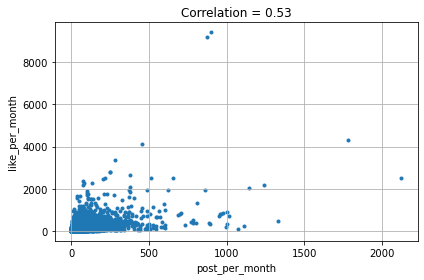

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def metric_pair_plot(churn_data, metric1='',metric2=''):
    met1_series = churn_data[metric1]
    met2_series = churn_data[metric2]

    corr = met1_series.corr(met2_series)

    plt.scatter(met1_series, met2_series, marker='.')

    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title('Correlation = %.2f' % corr)
    plt.tight_layout()
    plt.grid()
    return plt

dataset=get_dataset(d_obs_start, d_obs_end, metric_period)
stats=dataset_stats(dataset)
scores=metric_scores(dataset, stats)
print(scores.columns)

#metric_pair_plot(scores, "adview_per_month", "dislike_per_month")
metric_pair_plot(dataset, "post_per_month", "like_per_month")


<module 'matplotlib.pyplot' from 'C:\\bin\\Anaconda3\\envs\\fightchurn\\lib\\site-packages\\matplotlib\\pyplot.py'>

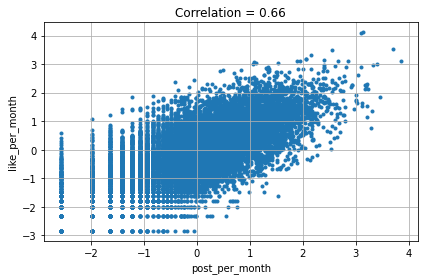

In [7]:
metric_pair_plot(scores, "post_per_month", "like_per_month")

## dataset correlation (§6.2)

In [8]:
def dataset_correlation_matrix(churn_data):
    churn_data = churn_data.reindex(sorted(churn_data.columns), axis=1)
    corr_df = churn_data.corr()
    return corr_df

corr=dataset_correlation_matrix(dataset)
print(corr)


                     account_tenure  adview_per_month  dislike_per_month  \
account_tenure             1.000000          0.047977           0.062620   
adview_per_month           0.047977          1.000000           0.276482   
dislike_per_month          0.062620          0.276482           1.000000   
is_churn                  -0.032156         -0.039886          -0.045385   
like_per_month             0.054076          0.692592           0.332353   
message_per_month          0.046430          0.051607           0.096207   
newfriend_per_month        0.077213          0.547203           0.344747   
post_per_month             0.063433          0.474725           0.337520   
reply_per_month            0.047805          0.040750           0.095245   
unfriend_per_month         0.059253          0.013293          -0.000876   

                     is_churn  like_per_month  message_per_month  \
account_tenure      -0.032156        0.054076           0.046430   
adview_per_month    -0.0398

In [9]:
corr_scores_df=dataset_correlation_matrix(scores)
print(corr)


                     account_tenure  adview_per_month  dislike_per_month  \
account_tenure             1.000000          0.047977           0.062620   
adview_per_month           0.047977          1.000000           0.276482   
dislike_per_month          0.062620          0.276482           1.000000   
is_churn                  -0.032156         -0.039886          -0.045385   
like_per_month             0.054076          0.692592           0.332353   
message_per_month          0.046430          0.051607           0.096207   
newfriend_per_month        0.077213          0.547203           0.344747   
post_per_month             0.063433          0.474725           0.337520   
reply_per_month            0.047805          0.040750           0.095245   
unfriend_per_month         0.059253          0.013293          -0.000876   

                     is_churn  like_per_month  message_per_month  \
account_tenure      -0.032156        0.054076           0.046430   
adview_per_month    -0.0398

## Apply metric groups (§6.3)

In [10]:
import numpy as np

import pandas as pd
import numpy as np
import os

def apply_metric_groups(score_data, load_mat_df):
    #data_2group = score_data.drop('is_churn',axis=1)
    data_2group = score_data
    load_mat_ndarray = load_mat_df.to_numpy()

    # Make sure the data is in the same column order as the rows of the loading matrix
    ndarray_2group = data_2group[load_mat_df.index.values].to_numpy()
    grouped_ndarray = np.matmul(ndarray_2group, load_mat_ndarray)

    churn_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=score_data.index)

    churn_data_grouped['is_churn'] = score_data['is_churn']
    return churn_data_grouped


churn_data_grouped=apply_metric_groups(scores, corr_scores_df)
print(churn_data_grouped)


                            account_tenure adview_per_month dislike_per_month  \
account_id observation_date                                                     
16         2020-03-01            -0.624608         -2.56207          -1.73451   
24         2020-03-01             -0.65204         -1.09054          -2.26659   
118        2020-03-01            -0.859869          -1.9978          -1.07324   
144        2020-03-01           -0.0149927          1.86868           1.63804   
157        2020-03-01             -1.17304         -7.40994          -5.40395   
...                                    ...              ...               ...   
12049      2020-04-04             -3.16084         -4.84626          -3.57635   
12052      2020-04-04             -2.21112         0.502338           1.24691   
12054      2020-04-04             -1.38156          3.23843           2.96257   
12082      2020-04-04               -1.994          0.88827          0.574741   
12084      2020-04-04       

## Find metric groups (§6.4)
Metrics showing high correlations to other metrics are grouped together.

In [11]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# you can find the routine in the module churnmodels.statistics
def make_load_matrix(labeled_column_df,metric_columns,relabled_count,corr):
    load_mat = np.zeros((len(metric_columns), len(relabled_count)))
    for row in labeled_column_df.iterrows():
        orig_col = metric_columns.index(row[1][1])
        if relabled_count[row[1][0]]>1:
            load_mat[orig_col, row[1][0]] = 1.0/  (np.sqrt(corr) * float(relabled_count[row[1][0]])  )
        else:
            load_mat[orig_col, row[1][0]] = 1.0

    is_group = load_mat.astype(bool).sum(axis=0) > 1
    column_names=['metric_group_{}'.format(d + 1) if is_group[d]
                      else labeled_column_df.loc[labeled_column_df['group']==d,'column'].iloc[0]
                      for d in range(0, load_mat.shape[1])]
    loadmat_df = pd.DataFrame(load_mat, index=metric_columns, columns=column_names)
    loadmat_df['name'] = loadmat_df.index
    sort_cols = list(loadmat_df.columns.values)
    sort_order = [False] * loadmat_df.shape[1]
    sort_order[-1] = True
    loadmat_df = loadmat_df.sort_values(sort_cols, ascending=sort_order)
    loadmat_df = loadmat_df.drop('name', axis=1)
    return loadmat_df


def relabel_clusters(labels,metric_columns):
    cluster_count = Counter(labels)
    cluster_order = {cluster[0]: idx for idx, cluster in enumerate(cluster_count.most_common())}
    relabeled_clusters = [cluster_order[l] for l in labels]
    relabled_count = Counter(relabeled_clusters)
    labeled_column_df = pd.DataFrame({'group': relabeled_clusters, 'column': metric_columns})\
        .sort_values(['group', 'column'], ascending=[True, True])
    return labeled_column_df, relabled_count

def find_correlation_clusters(corr, corr_thresh=0.5):
    dissimilarity = 1.0 - corr
    hierarchy = linkage(squareform(dissimilarity), method='single')
    diss_thresh = 1.0 - corr_thresh
    labels = fcluster(hierarchy, diss_thresh, criterion='distance')
    return labels

def find_metric_groups(score_data,group_corr_thresh=0.5):
    #score_save_path=data_set_path.replace('.csv','_scores.csv')
    #assert os.path.isfile(score_save_path),'You must run listing 5.3 or 7.5 to save metric scores first'
    #score_data = pd.read_csv(score_save_path,index_col=[0,1])
    if 'is_churn' in score_data.columns:
        score_data.drop('is_churn',axis=1,inplace=True)
    metric_columns = list(score_data.columns.values)

    labels = find_correlation_clusters(score_data.corr(),group_corr_thresh)
    labeled_column_df, relabled_count = relabel_clusters(labels,metric_columns)
    loadmat_df = make_load_matrix(labeled_column_df, metric_columns, relabled_count,group_corr_thresh)
    #save_load_matrix(data_set_path,loadmat_df,labeled_column_df)
    return loadmat_df

    
loadmat_df=find_metric_groups(scores)

# reordering of the scores columns -> reordered correlation matrix
ordered_corr_df=scores[loadmat_df.index.values].corr()
print(ordered_corr_df)


                     adview_per_month  like_per_month  newfriend_per_month  \
adview_per_month             1.000000        0.675326             0.602719   
like_per_month               0.675326        1.000000             0.596894   
newfriend_per_month          0.602719        0.596894             1.000000   
post_per_month               0.658962        0.664208             0.591977   
message_per_month            0.122033        0.116915             0.078589   
reply_per_month              0.072890        0.068107             0.034878   
dislike_per_month            0.449754        0.460637             0.406368   
unfriend_per_month           0.012204        0.019887             0.019764   
account_tenure               0.098595        0.109182             0.098733   

                     post_per_month  message_per_month  reply_per_month  \
adview_per_month           0.658962           0.122033         0.072890   
like_per_month             0.664208           0.116915         0.0681